# Visualize pose space before and after NN

In [1]:
import cv2
import joblib
import numpy as np
import pandas as pd
import colorcet as cc
import seaborn as sns
import matplotlib.pyplot as plt
from toolz import first
from pynndescent import NNDescent
from sklearn.decomposition import PCA
from aging.size_norm.data import clean
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend
import warnings
warnings.simplefilter('ignore')
import umap

In [2]:
ONTOGENY_AGE_CMAP = "cubehelix"

In [3]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "size-normalization", tight_layout=False, dpi=600)

In [4]:
def smooth_clean(frame):
    frame = clean(frame)
    frame = cv2.GaussianBlur(frame, (21, 21), 1.5, 1)
    return frame

In [5]:
thinning = 5

In [6]:
version = 12  # arhmm version
tmp = joblib.load(f"/n/scratch/users/w/wg41/aging-aligned-frames_version{version:02d}.p")
all_frames = tmp["frames"]
all_recon_frames = tmp["recon"]

In [7]:
len(all_frames)

253

In [8]:
len(first(all_frames.values()))

9000

## Apply PCA

In [9]:
def fit_pca(frames):
    np.random.seed(0)
    pca = PCA(n_components=10)
    pca.fit(
        np.concatenate(
            [
                v[np.random.permutation(np.arange(len(v)))[:500]]
                for v in frames.values()
            ],
            axis=0,
        ).reshape(-1, (80 * 80))
    )
    return pca


def apply_pca(pca, frames):
    np.random.seed(0)
    x = []
    y = []
    for k, v in frames.items():
        v = v[np.random.permutation(len(v))[:5_000]]
        y.extend([k[-1]] * len(v))
        x.append(v)
    x = np.concatenate(x, axis=0)
    x = x.reshape(len(x), -1)
    y = np.array(y)

    pcs = np.concatenate(
        [pca.transform(batch) for batch in np.array_split(x, len(x) // 50_00)], axis=0
    )
    return pcs, y

In [10]:
pre_pca = fit_pca(all_frames)
post_pca = fit_pca(all_recon_frames)

pre_x_pcs, pre_y = apply_pca(pre_pca, all_frames)
post_x_pcs, post_y = apply_pca(post_pca, all_recon_frames)

In [11]:
pre_pc_df = pd.DataFrame(dict(enumerate(StandardScaler().fit_transform(pre_x_pcs).T)))
pre_pc_df['age'] = pre_y

avg_pc = pre_pc_df.groupby('age').mean()
raw_dists = pdist(avg_pc.to_numpy(), metric='euclidean')

post_pc_df = pd.DataFrame(dict(enumerate(StandardScaler().fit_transform(post_x_pcs).T)))
post_pc_df['age'] = post_y

avg_pc = post_pc_df.groupby('age').mean()
xform_dists = pdist(avg_pc.to_numpy(), metric='euclidean')

In [12]:
assert len(pre_x_pcs) == len(post_x_pcs)

In [13]:
assert np.all(pre_y == post_y)

In [14]:
permutation = np.random.permutation(len(pre_x_pcs))[::thinning]

## Visualize manifold in a few different ways

Label by age

- PCA
- UMAP

(0.4, 1.0)

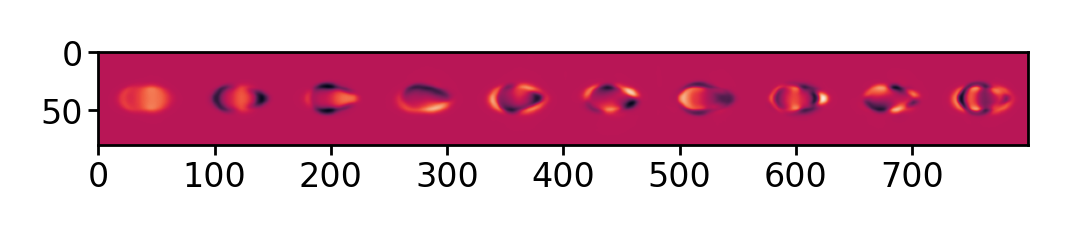

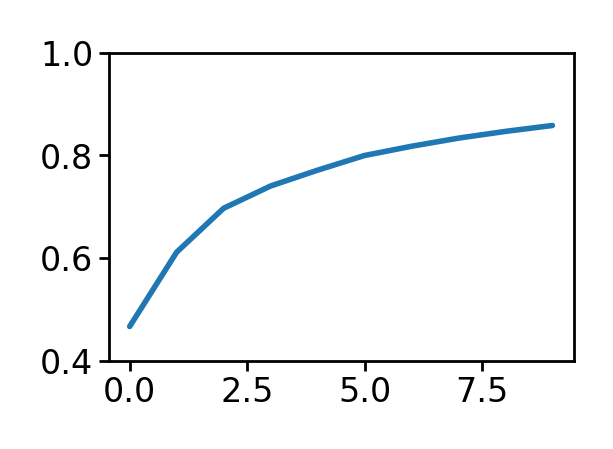

In [16]:
components = pre_pca.components_.reshape(len(pre_pca.components_), 80, 80)
components = np.concatenate(components, axis=1)
plt.imshow(components)

fig = plt.figure(figsize=(1.5, 1))
plt.plot(np.cumsum(pre_pca.explained_variance_ratio_))
plt.ylim(0.4, 1)

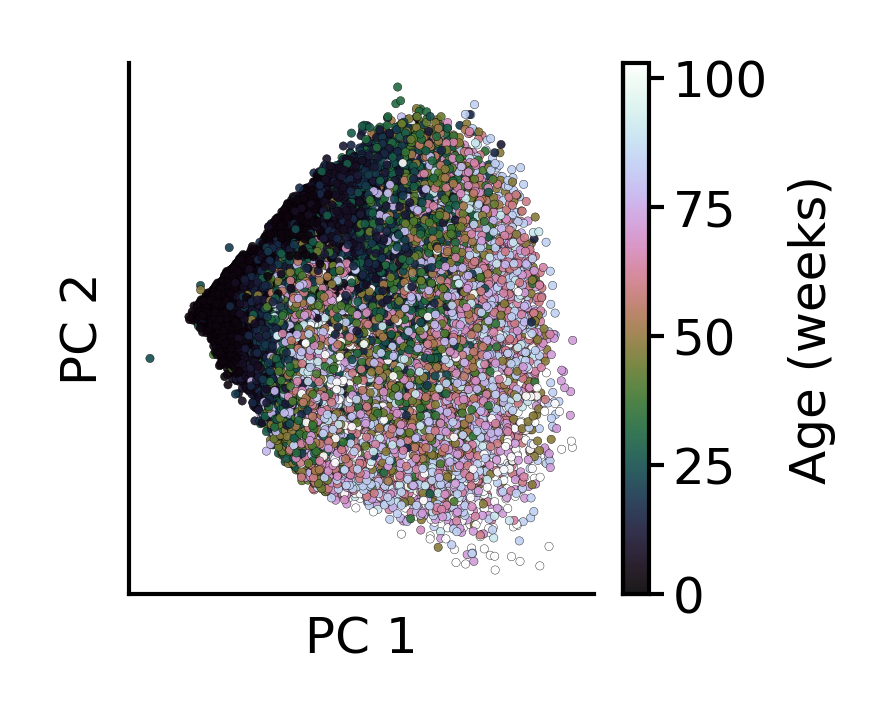

In [17]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *pre_x_pcs[:, :2][permutation].T,
    c=pre_y[permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    vmin=0,
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, 'pre-model-pcs-across-age', dpi=700);

In [18]:
umap_mdl = umap.UMAP(random_state=0)
pre_latents = umap_mdl.fit_transform(pre_x_pcs[permutation])

IOStream.flush timed out


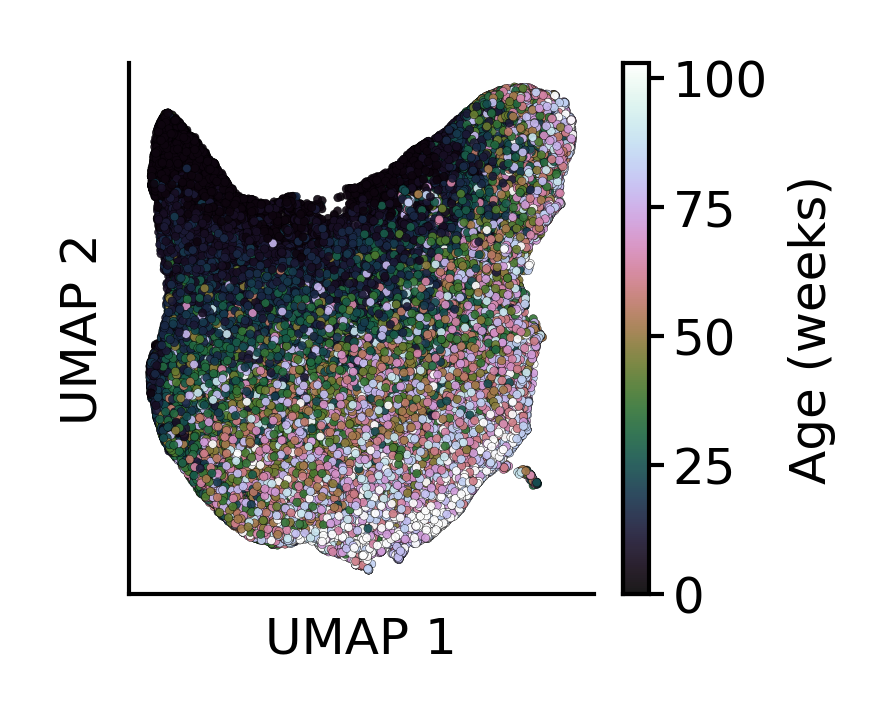

In [19]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *pre_latents.T,
    c=pre_y[permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    vmin=0
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, 'pre-model-umap-across-age', dpi=700);

## After NN

(0.4, 1.0)

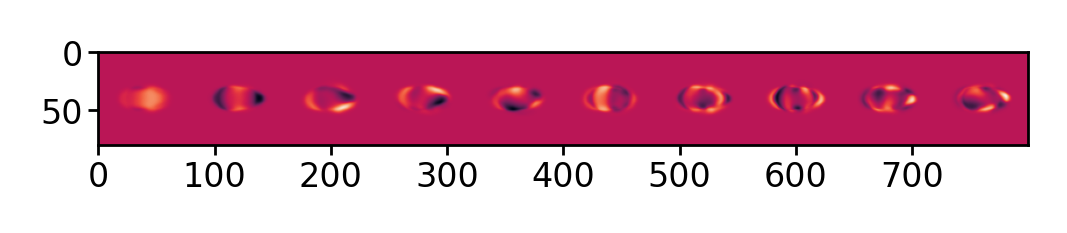

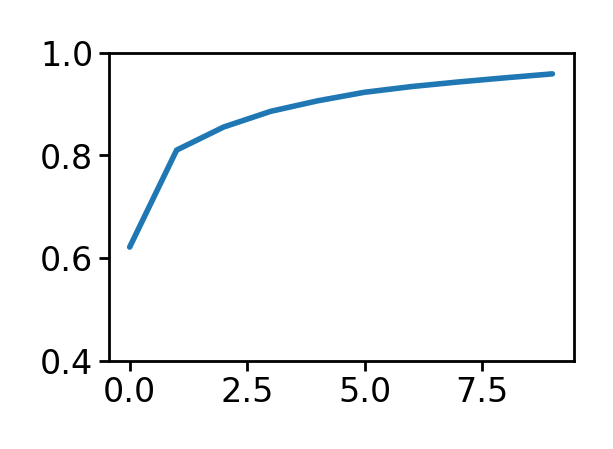

In [20]:
components = post_pca.components_.reshape(len(post_pca.components_), 80, 80)
components = np.concatenate(components, axis=1)
plt.imshow(components)

fig = plt.figure(figsize=(1.5, 1))
plt.plot(np.cumsum(post_pca.explained_variance_ratio_))
plt.ylim(0.4, 1)

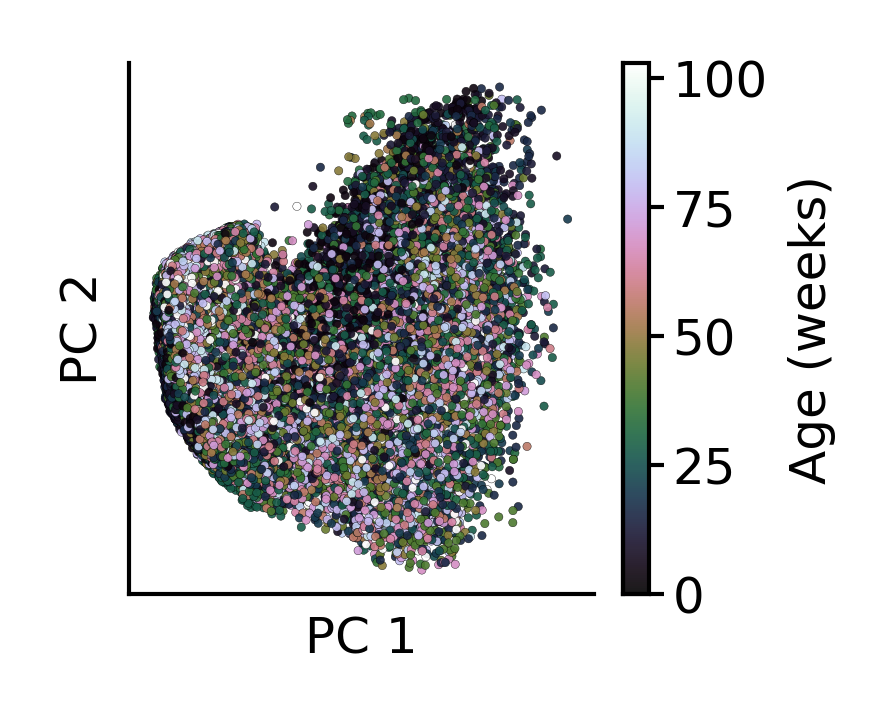

In [21]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *post_x_pcs[:, :2][permutation].T,
    c=post_y[permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    vmin=0
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2", xlim=(None, 1000))
sns.despine()
saver(fig, 'post-model-pcs-across-age', dpi=700);

In [22]:
umap_mdl = umap.UMAP(random_state=0)
post_latents = umap_mdl.fit_transform(post_x_pcs[permutation])

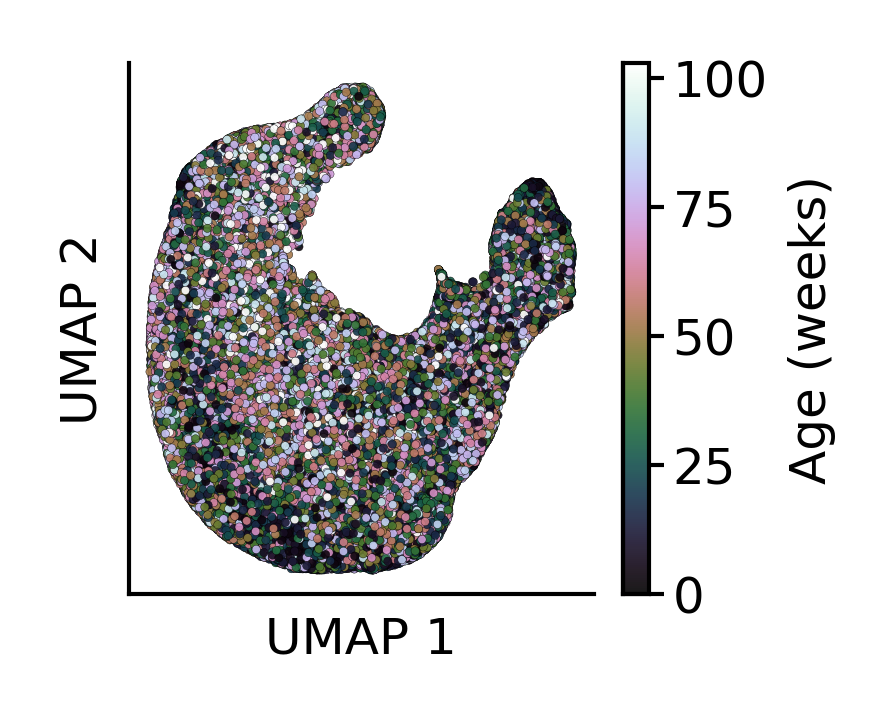

In [23]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *post_latents.T,
    c=post_y[permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    vmin=0
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, "post-model-umap-across-age", dpi=700);

## k-means clustering of post-NN space, apply coloring to pre-NN space

In [60]:
from sklearn.cluster import k_means

In [61]:
def get_avg_frames(labels, frames):
    np.random.seed(0)
    avgs = {}
    counts = {}
    for (k, v), l in zip(frames.items(), np.array_split(labels, len(frames))):
        v = v[np.random.permutation(len(v))[:5_000]]
        for i in np.unique(labels):
            if i not in avgs:
                avgs[i] = np.sum(v[l == i], axis=0)
                counts[i] = np.sum(l == i)
            else:
                avgs[i] = avgs[i] + np.sum(v[l == i], axis=0)
                counts[i] = counts[i] + np.sum(l == i)
    return {k: v / counts[k] for k, v in avgs.items()}

In [62]:
centroid, labels, inertia = k_means(
    post_x_pcs, n_clusters=5, random_state=0
)

In [63]:
recon_frame_clusters = get_avg_frames(labels, all_recon_frames)
frame_clusters = get_avg_frames(labels, all_frames)

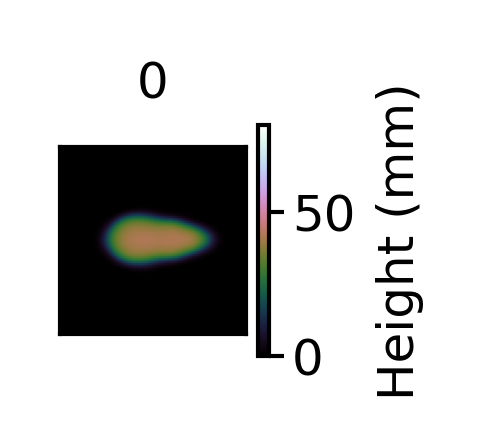

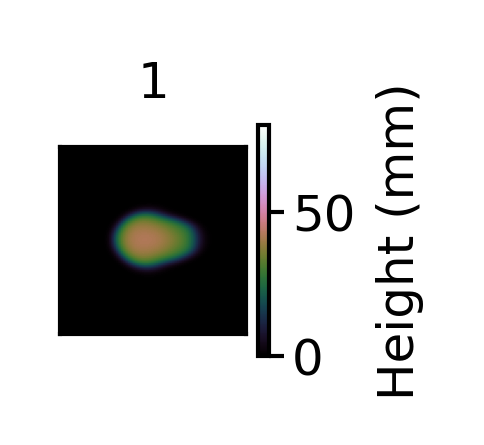

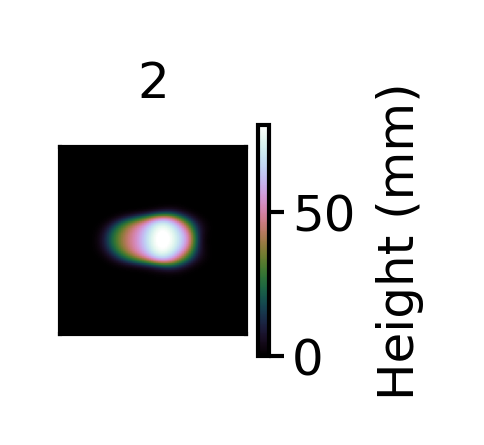

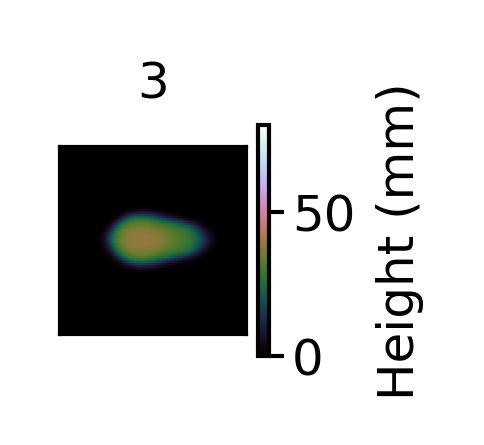

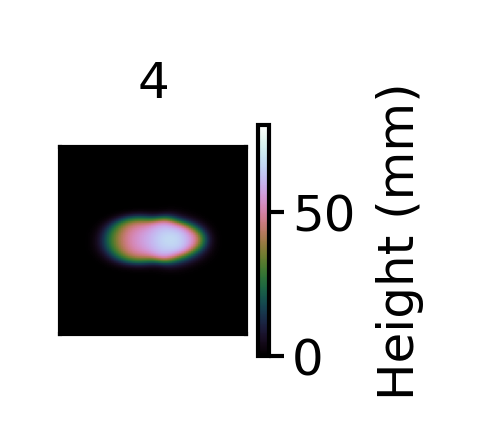

In [64]:
for k, v in frame_clusters.items():
    fig = figure(0.5, 0.5)
    ax = fig.gca()
    im = ax.imshow(v, vmax=80, cmap=ONTOGENY_AGE_CMAP, vmin=0)
    ax.set(xticks=[], yticks=[])
    fig.colorbar(im, ax=ax, label="Height (mm)")
    plt.title(k)
    saver(fig, f"avg-cluster-{k}-pre-pose-post-fit-to-pre");

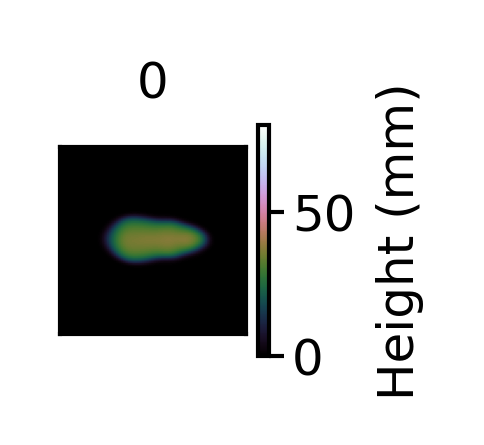

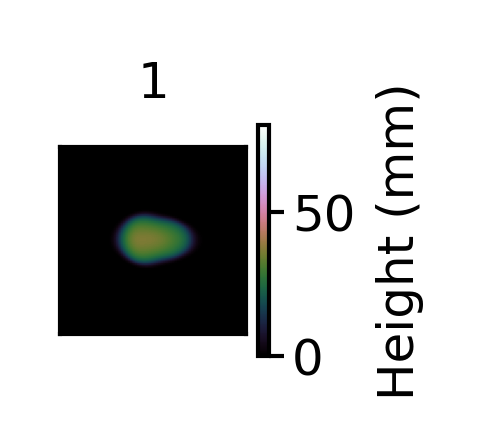

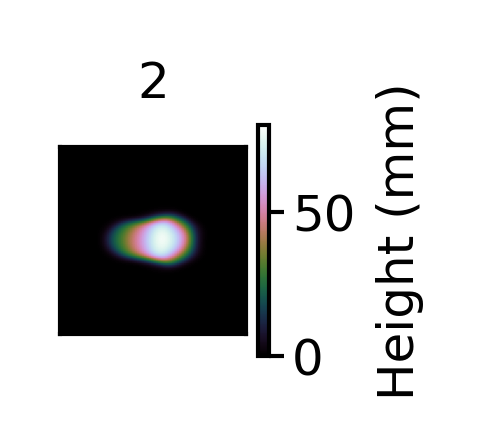

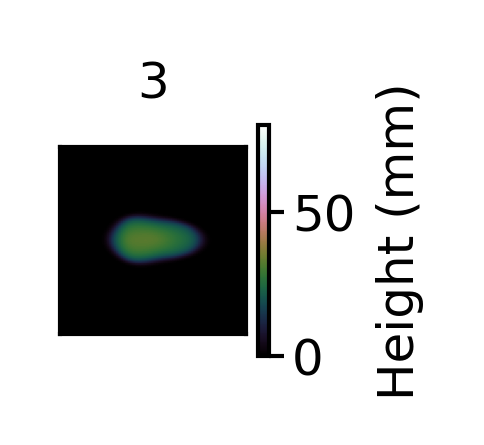

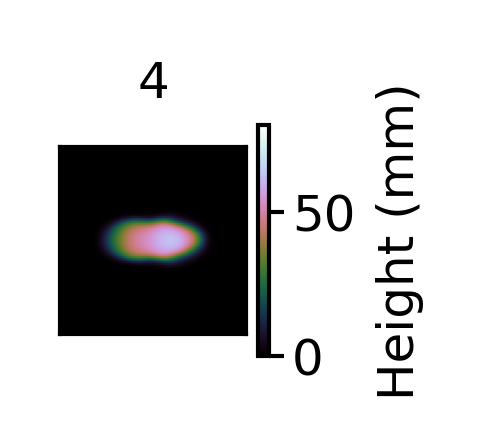

In [65]:
for k, v in recon_frame_clusters.items():
    fig = figure(0.5, 0.5)
    ax = fig.gca()
    im = ax.imshow(v, vmax=80, cmap=ONTOGENY_AGE_CMAP, vmin=0)
    ax.set(xticks=[], yticks=[])
    fig.colorbar(im, ax=ax, label="Height (mm)")
    plt.title(k)
    saver(fig, f"avg-cluster-{k}-post-pose-post-fit-to-pre");

In [66]:
centroid.shape

(5, 10)

In [67]:
pre_centroids = {k: np.mean(pre_x_pcs[labels == k], axis=0) for k in sorted(np.unique(labels))}
pre_centroids = np.array(list(pre_centroids.values()))

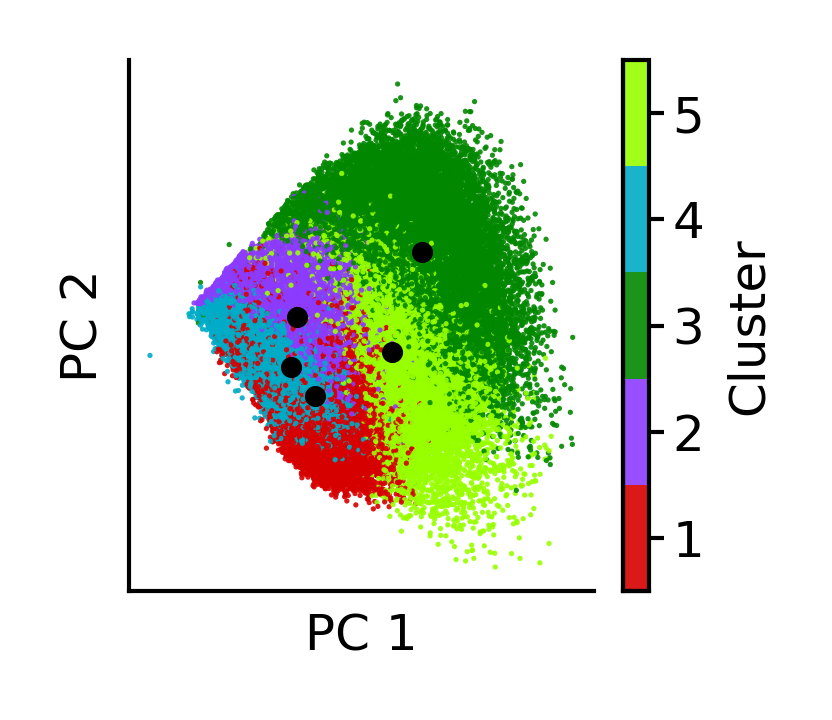

In [68]:
fig = figure(1.25, 1.15)
ax = fig.gca()
ax.scatter(*pre_centroids[:, :2].T, color='k', s=3, zorder=2)
im = ax.scatter(
    *pre_x_pcs[:, :2][permutation].T,
    c=labels[permutation],
    cmap=cc.cm.glasbey,
    s=0.4,
    lw=0,
    # ec="k",
    alpha=0.9,
    rasterized=True,
    vmax=256,
)
cb = fig.colorbar(im, label="Cluster", ax=ax, boundaries=[0, 1, 2, 3, 4, 5])
cb.set_ticks(np.arange(0.5, 5, 1))
cb.set_ticklabels((np.arange(0.5, 5, 1) + 0.5).astype(int))
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, 'pre-model-pcs-across-pose-clusters-post-fit', dpi=700);

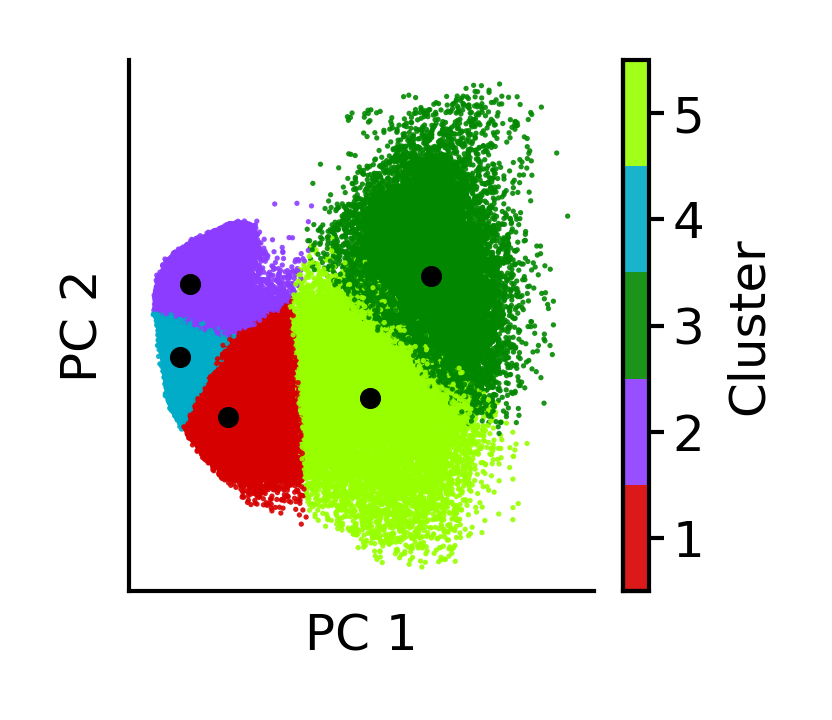

In [69]:
fig = figure(1.25, 1.15)
ax = fig.gca()
ax.scatter(*centroid[:, :2].T, color='k', s=3, zorder=2)
im = ax.scatter(
    *post_x_pcs[:, :2][permutation].T,
    c=labels[permutation],
    cmap=cc.cm.glasbey,
    s=0.4,
    lw=0,
    # ec="k",
    alpha=0.9,
    rasterized=True,
    vmax=256
)
cb = fig.colorbar(im, label="Cluster", ax=ax, boundaries=[0, 1, 2, 3, 4, 5])
cb.set_ticks(np.arange(0.5, 5, 1))
cb.set_ticklabels((np.arange(0.5, 5, 1) + 0.5).astype(int))
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2", xlim=(None, 1000))
sns.despine()
saver(fig, 'post-model-pcs-across-pose-clusters-post-fit', dpi=700);

In [70]:
pre_centroids = {k: np.mean(pre_latents[labels[permutation] == k], axis=0) for k in sorted(np.unique(labels))}
pre_centroids = np.array(list(pre_centroids.values()))

post_centroids = {k: np.mean(post_latents[labels[permutation] == k], axis=0) for k in sorted(np.unique(labels))}
post_centroids = np.array(list(post_centroids.values()))

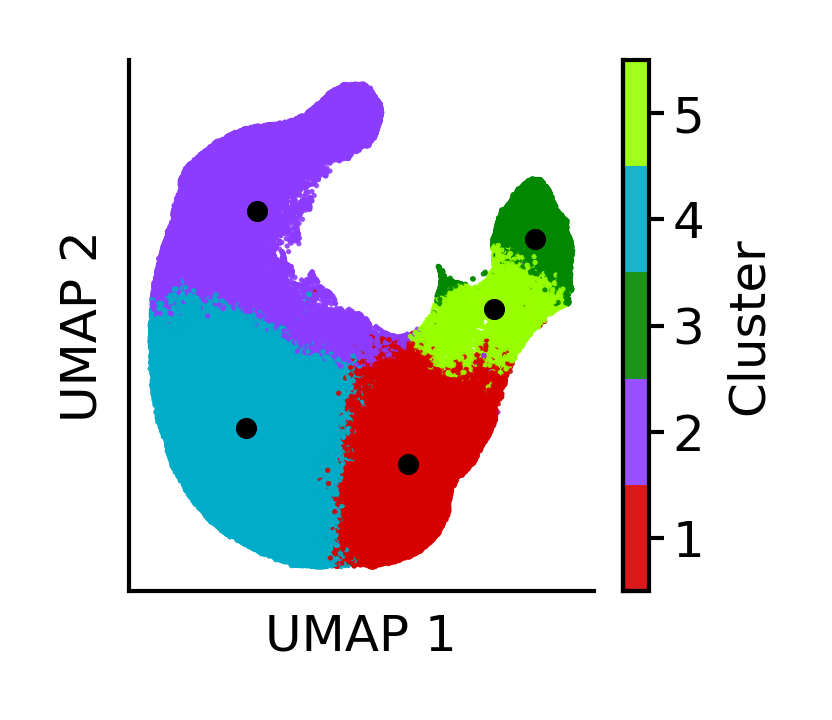

In [71]:
fig = figure(1.25, 1.15)
ax = fig.gca()
ax.scatter(*post_centroids[:, :2].T, color='k', s=3, zorder=2)
im = ax.scatter(
    *post_latents.T,
    c=labels[permutation],
    cmap=cc.cm.glasbey,
    s=0.4,
    lw=0,
    # ec="k",
    alpha=0.9,
    rasterized=True,
    vmax=256
)
cb = fig.colorbar(im, label="Cluster", ax=ax, boundaries=[0, 1, 2, 3, 4, 5])
cb.set_ticks(np.arange(0.5, 5, 1))
cb.set_ticklabels((np.arange(0.5, 5, 1) + 0.5).astype(int))
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, "post-model-umap-across-pose-clusters-post-fit", dpi=700);

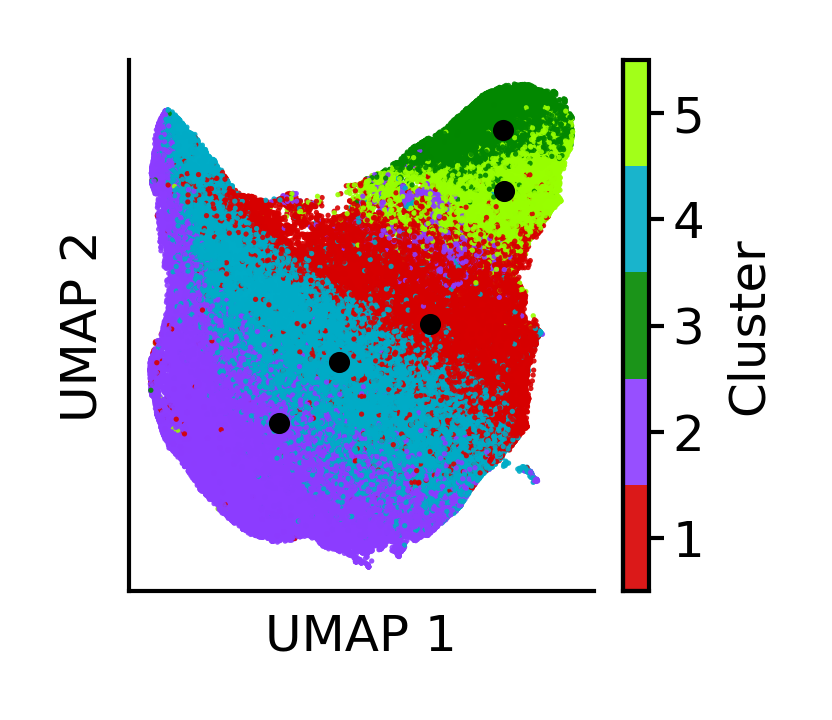

In [72]:
fig = figure(1.25, 1.15)
ax = fig.gca()
ax.scatter(*pre_centroids[:, :2].T, color='k', s=3, zorder=2)
im = ax.scatter(
    *pre_latents.T,
    c=labels[permutation],
    cmap=cc.cm.glasbey,
    s=0.4,
    lw=0,
    # ec="k",
    alpha=0.9,
    rasterized=True,
    vmax=256
)
cb = fig.colorbar(im, label="Cluster", ax=ax, boundaries=[0, 1, 2, 3, 4, 5])
cb.set_ticks(np.arange(0.5, 5, 1))
cb.set_ticklabels((np.arange(0.5, 5, 1) + 0.5).astype(int))
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, "pre-model-umap-across-pose-clusters-post-fit", dpi=700);

### Cluster on pre

In [73]:
centroid, labels, inertia = k_means(
    pre_x_pcs, n_clusters=5, random_state=0
)

In [74]:
recon_frame_clusters = get_avg_frames(labels, all_recon_frames)
frame_clusters = get_avg_frames(labels, all_frames)

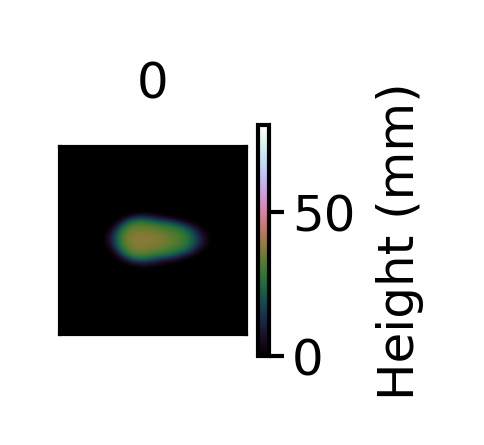

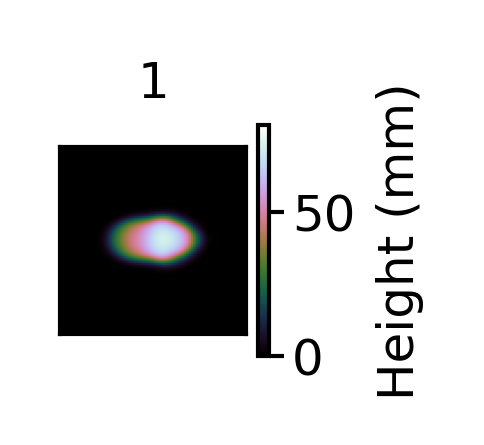

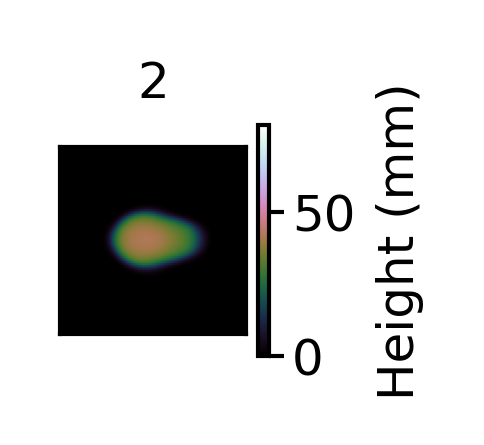

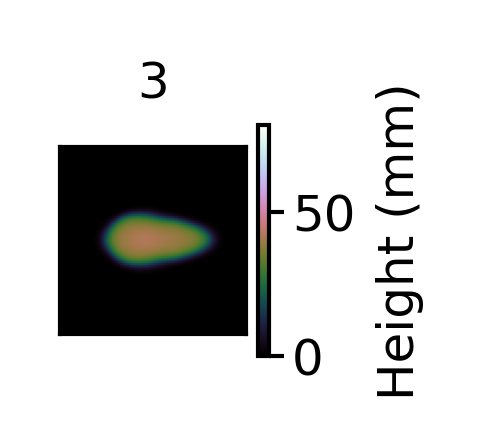

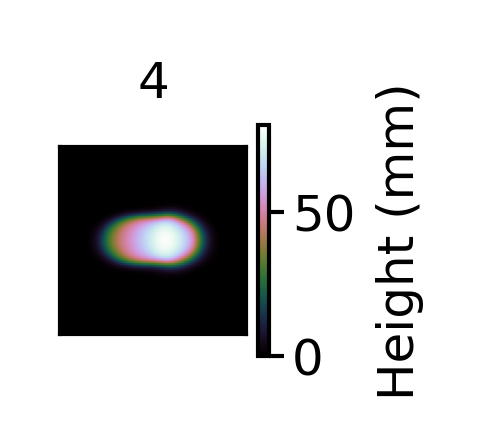

In [75]:
for k, v in frame_clusters.items():
    fig = figure(0.5, 0.5)
    ax = fig.gca()
    im = ax.imshow(v, vmax=80, cmap=ONTOGENY_AGE_CMAP, vmin=0)
    ax.set(xticks=[], yticks=[])
    fig.colorbar(im, ax=ax, label="Height (mm)")
    plt.title(k)
    saver(fig, f"avg-cluster-{k}-pre-pose-pre-fit-to-post");

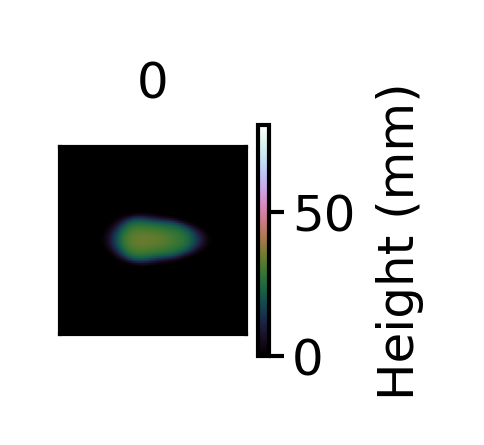

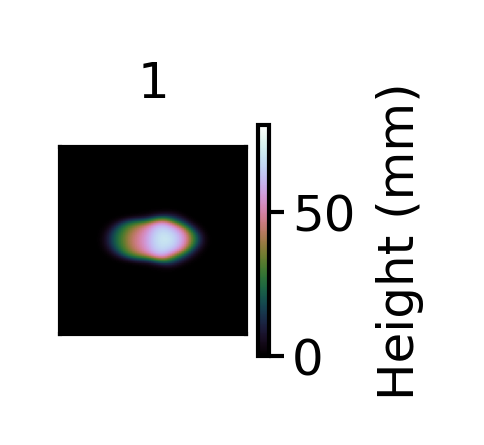

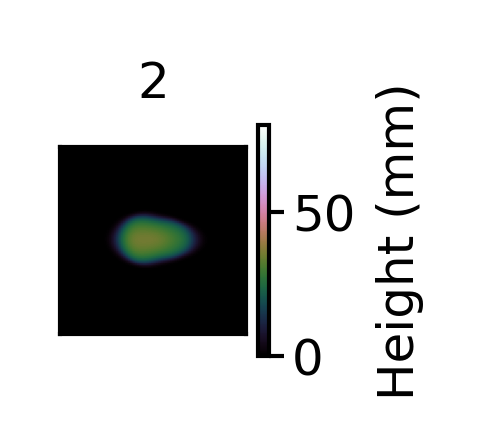

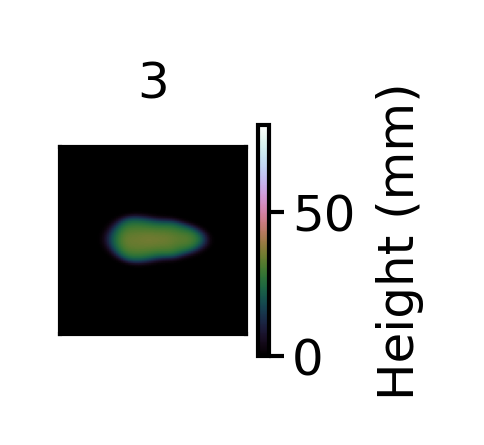

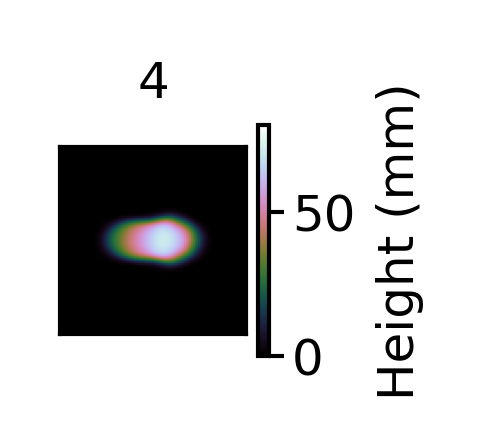

In [76]:
for k, v in recon_frame_clusters.items():
    fig = figure(0.5, 0.5)
    ax = fig.gca()
    im = ax.imshow(v, vmax=80, cmap=ONTOGENY_AGE_CMAP, vmin=0)
    ax.set(xticks=[], yticks=[])
    fig.colorbar(im, ax=ax, label="Height (mm)")
    plt.title(k)
    saver(fig, f"avg-cluster-{k}-post-pose-pre-fit-to-post");

In [77]:
centroid.shape

(5, 10)

In [78]:
post_centroids = {k: np.mean(post_x_pcs[labels == k], axis=0) for k in sorted(np.unique(labels))}
post_centroids = np.array(list(post_centroids.values()))

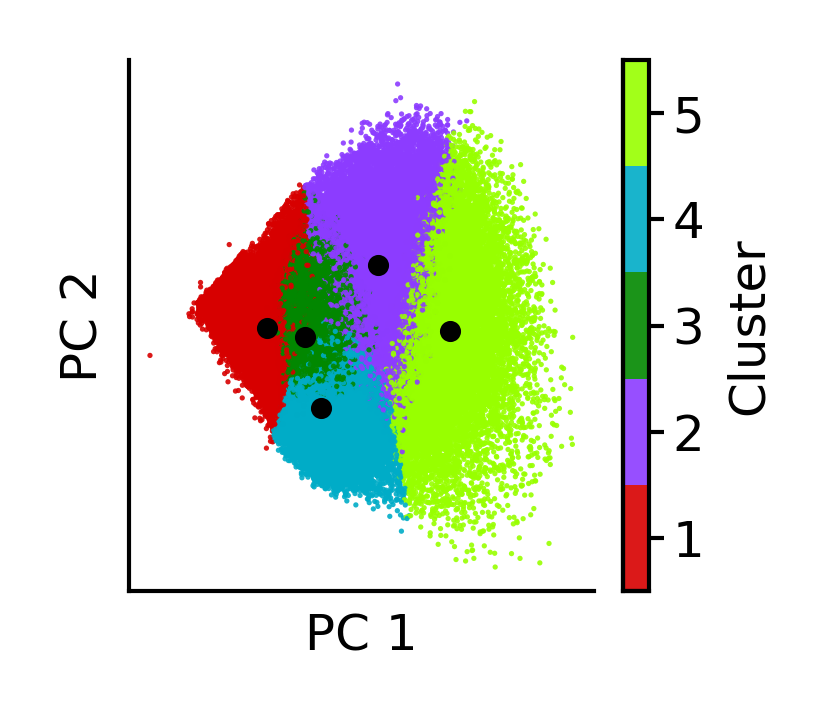

In [79]:
fig = figure(1.25, 1.15)
ax = fig.gca()
ax.scatter(*centroid[:, :2].T, color='k', s=3, zorder=2)
im = ax.scatter(
    *pre_x_pcs[:, :2][permutation].T,
    c=labels[permutation],
    cmap=cc.cm.glasbey,
    s=0.4,
    lw=0,
    # ec="k",
    alpha=0.9,
    rasterized=True,
    vmax=256,
)
cb = fig.colorbar(im, label="Cluster", ax=ax, boundaries=[0, 1, 2, 3, 4, 5])
cb.set_ticks(np.arange(0.5, 5, 1))
cb.set_ticklabels((np.arange(0.5, 5, 1) + 0.5).astype(int))
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, 'pre-model-pcs-across-pose-clusters-pre-fit', dpi=700);

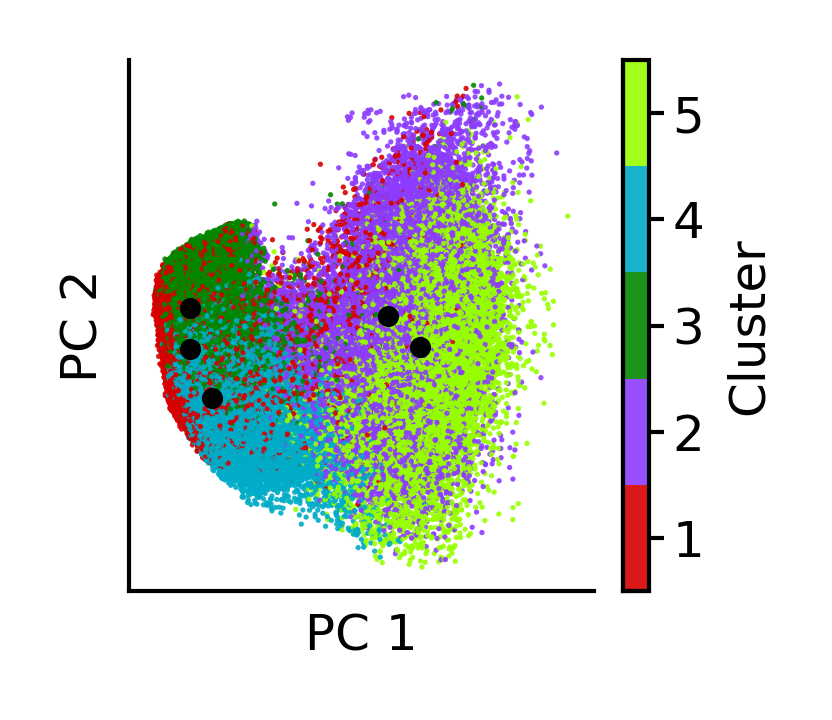

In [80]:
fig = figure(1.25, 1.15)
ax = fig.gca()
ax.scatter(*post_centroids[:, :2].T, color='k', s=3, zorder=2)
im = ax.scatter(
    *post_x_pcs[:, :2][permutation].T,
    c=labels[permutation],
    cmap=cc.cm.glasbey,
    s=0.4,
    lw=0,
    # ec="k",
    alpha=0.9,
    rasterized=True,
    vmax=256
)
cb = fig.colorbar(im, label="Cluster", ax=ax, boundaries=[0, 1, 2, 3, 4, 5])
cb.set_ticks(np.arange(0.5, 5, 1))
cb.set_ticklabels((np.arange(0.5, 5, 1) + 0.5).astype(int))
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2", xlim=(None, 1000))
sns.despine()
saver(fig, 'post-model-pcs-across-pose-clusters-pre-fit', dpi=700);

In [81]:
pre_centroids = {k: np.mean(pre_latents[labels[permutation] == k], axis=0) for k in sorted(np.unique(labels))}
pre_centroids = np.array(list(pre_centroids.values()))

post_centroids = {k: np.mean(post_latents[labels[permutation] == k], axis=0) for k in sorted(np.unique(labels))}
post_centroids = np.array(list(post_centroids.values()))

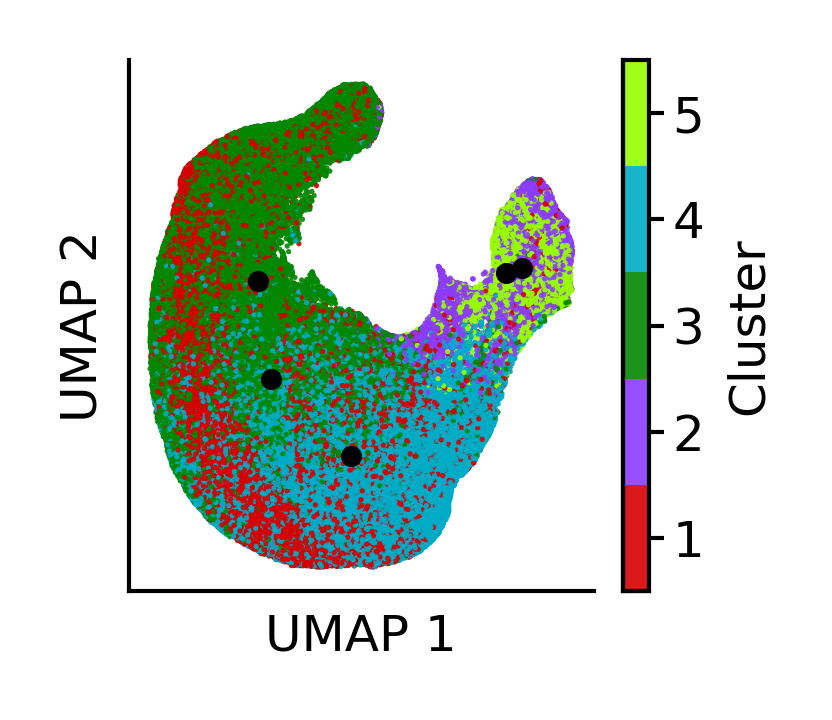

In [82]:
fig = figure(1.25, 1.15)
ax = fig.gca()
ax.scatter(*post_centroids[:, :2].T, color='k', s=3, zorder=2)
im = ax.scatter(
    *post_latents.T,
    c=labels[permutation],
    cmap=cc.cm.glasbey,
    s=0.4,
    lw=0,
    # ec="k",
    alpha=0.9,
    rasterized=True,
    vmax=256
)
cb = fig.colorbar(im, label="Cluster", ax=ax, boundaries=[0, 1, 2, 3, 4, 5])
cb.set_ticks(np.arange(0.5, 5, 1))
cb.set_ticklabels((np.arange(0.5, 5, 1) + 0.5).astype(int))
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, "post-model-umap-across-pose-clusters-pre-fit", dpi=700);

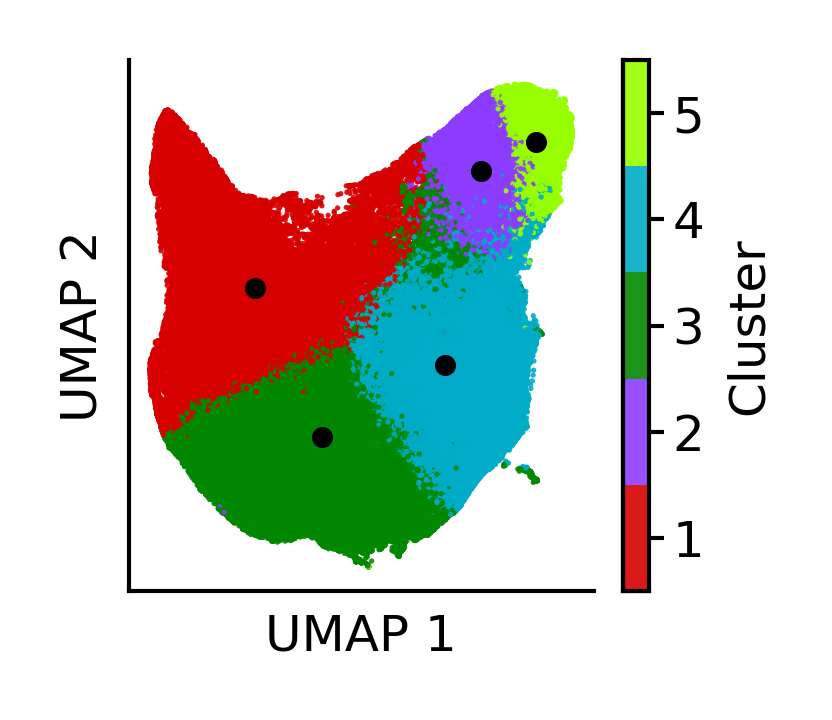

In [83]:
fig = figure(1.25, 1.15)
ax = fig.gca()
ax.scatter(*pre_centroids[:, :2].T, color='k', s=3, zorder=2)
im = ax.scatter(
    *pre_latents.T,
    c=labels[permutation],
    cmap=cc.cm.glasbey,
    s=0.4,
    lw=0,
    # ec="k",
    alpha=0.9,
    rasterized=True,
    vmax=256
)
cb = fig.colorbar(im, label="Cluster", ax=ax, boundaries=[0, 1, 2, 3, 4, 5])
cb.set_ticks(np.arange(0.5, 5, 1))
cb.set_ticklabels((np.arange(0.5, 5, 1) + 0.5).astype(int))
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, "pre-model-umap-across-pose-clusters-pre-fit", dpi=700);

## Comparison of nearest-neighbor ages

In [49]:
from scipy.spatial.distance import jensenshannon

In [50]:
pre_index = NNDescent(pre_x_pcs, n_neighbors=21)
post_index = NNDescent(post_x_pcs, n_neighbors=21)

In [51]:
nn = pre_index.neighbor_graph[0]
avg_nn_age_pre = np.abs(pre_y[nn[:, :1]] - pre_y[nn[:, 1:]])

nn = post_index.neighbor_graph[0]
avg_nn_age_post = np.abs(post_y[nn[:, :1]] - post_y[nn[:, 1:]])

In [52]:
n_neigh_pre = (avg_nn_age_pre > 0).sum(axis=1)
n_neigh_post = (avg_nn_age_post > 0).sum(axis=1)

In [53]:
jensenshannon(np.histogram(n_neigh_pre, bins=np.arange(22) - 0.5)[0],  np.histogram(n_neigh_post, bins=np.arange(22) - 0.5)[0])

0.21767601990453653

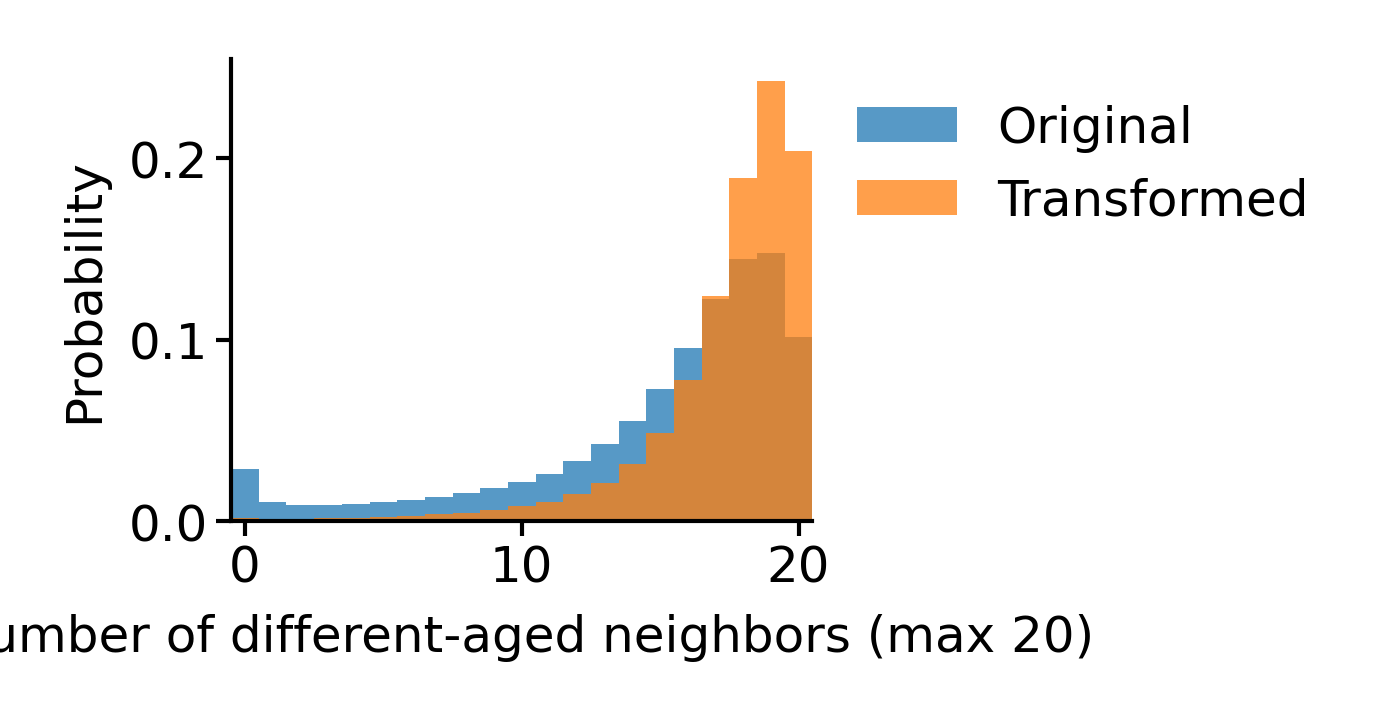

In [54]:
fig = figure(1.25, 1)
ax = sns.histplot(
    n_neigh_pre,
    bins=np.arange(22) - 0.5,
    element="step",
    label="Original",
    stat="probability",
    lw=0,
)
ax = sns.histplot(
    n_neigh_post,
    bins=np.arange(22) - 0.5,
    element="step",
    label="Transformed",
    stat="probability",
    lw=0,
)
ax.set(xlabel="Number of different-aged neighbors (max 20)", xlim=(-0.5, 20.5))
legend(ax)
sns.despine()
saver(fig, "nearest-neighbor-distributions");

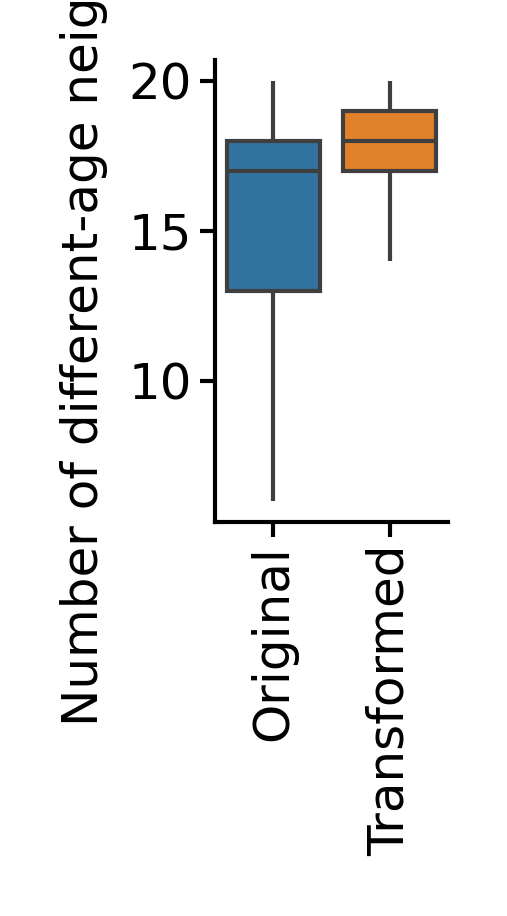

In [55]:
fig = figure(0.5, 1)
ax = sns.boxplot(
    data=[(avg_nn_age_pre > 0).sum(axis=1), (avg_nn_age_post > 0).sum(axis=1)],
    showcaps=False,
    showfliers=False,
    linewidth=0.5,
)
ax.set(
    ylabel="Number of different-age neighbors", xticklabels=["Original", "Transformed"]
)
plt.xticks(rotation=90)
sns.despine()
# saver(fig, "nearest-neighbor-age-diff");

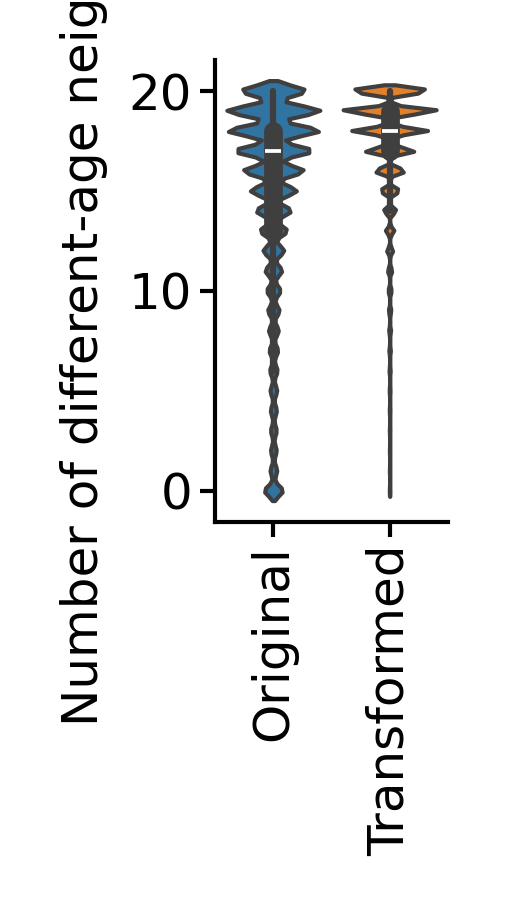

In [56]:
fig = figure(0.5, 1)
ax = sns.violinplot(
    data=[(avg_nn_age_pre > 0).sum(axis=1), (avg_nn_age_post > 0).sum(axis=1)],
    linewidth=0.5, bw=0.05
)
ax.set(
    ylabel="Number of different-age neighbors", xticklabels=["Original", "Transformed"]
)
plt.xticks(rotation=90)
sns.despine()
# saver(fig, "nearest-neighbor-age-diff-violin");

In [57]:
opt = {}
hists = {}
for num_neigh in range(5, 50, 5):
    pre_index = NNDescent(pre_x_pcs, n_neighbors=num_neigh + 1)
    post_index = NNDescent(post_x_pcs, n_neighbors=num_neigh + 1)

    nn = pre_index.neighbor_graph[0]
    avg_nn_age_pre = np.abs(pre_y[nn[:, :1]] - pre_y[nn[:, 1:]])

    nn = post_index.neighbor_graph[0]
    avg_nn_age_post = np.abs(post_y[nn[:, :1]] - post_y[nn[:, 1:]])

    n_neigh_pre = (avg_nn_age_pre > 0).sum(axis=1)
    n_neigh_post = (avg_nn_age_post > 0).sum(axis=1)

    h1 = np.histogram(n_neigh_pre, bins=np.arange(num_neigh + 2) - 0.5)[0]
    h2 = np.histogram(n_neigh_post, bins=np.arange(num_neigh + 2) - 0.5)[0]
    jsd = jensenshannon(h1, h2)
    opt[num_neigh] = jsd
    hists[num_neigh] = (h1, h2)
    print(num_neigh, jsd)

5 0.18973351269376892


SystemError: CPUDispatcher(<function nn_descent at 0x7f2f22f653f0>) returned a result with an exception set

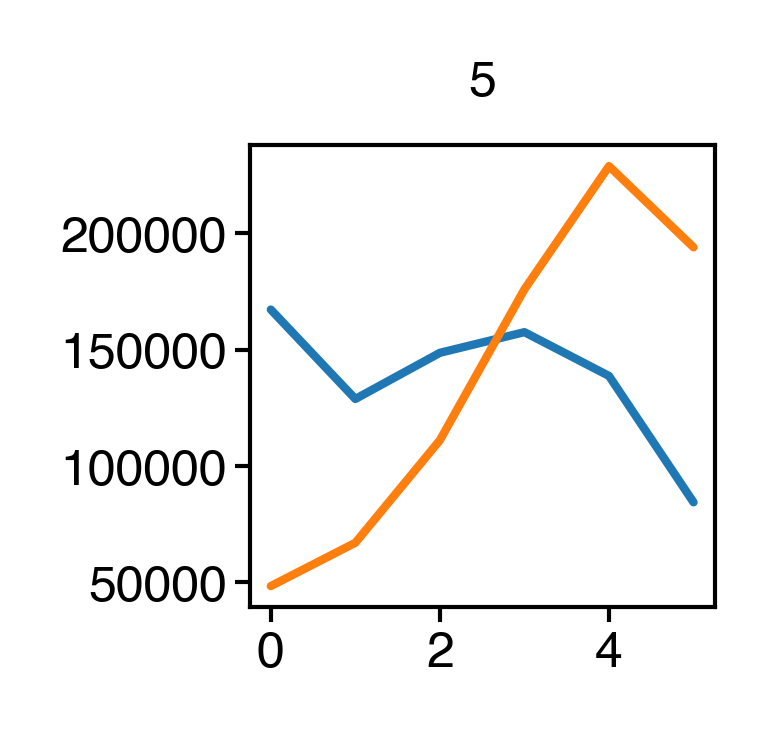

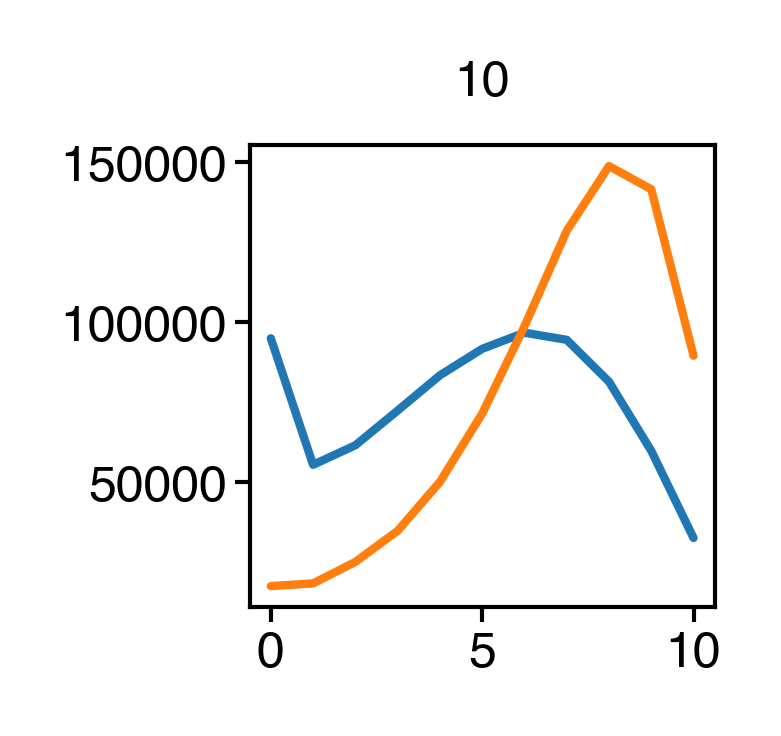

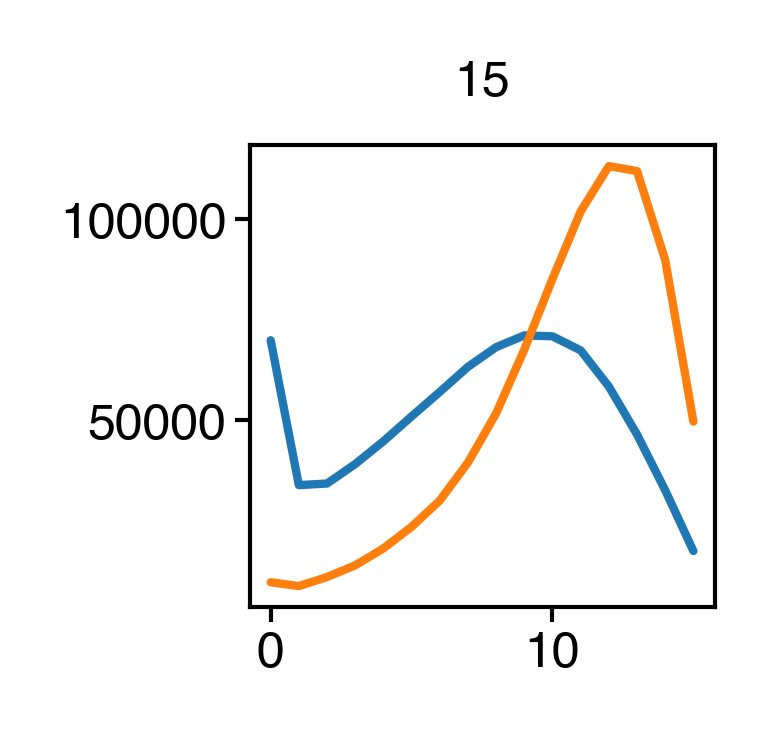

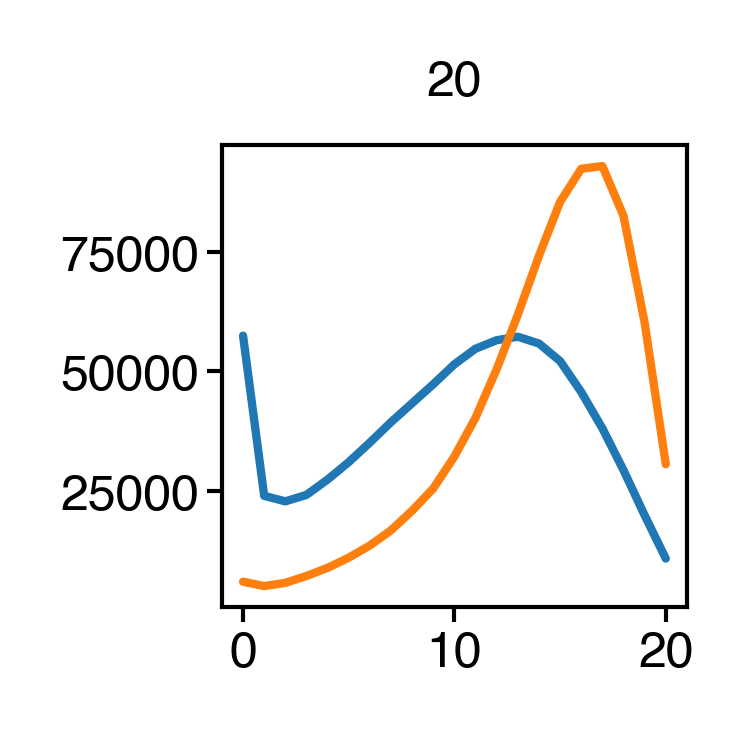

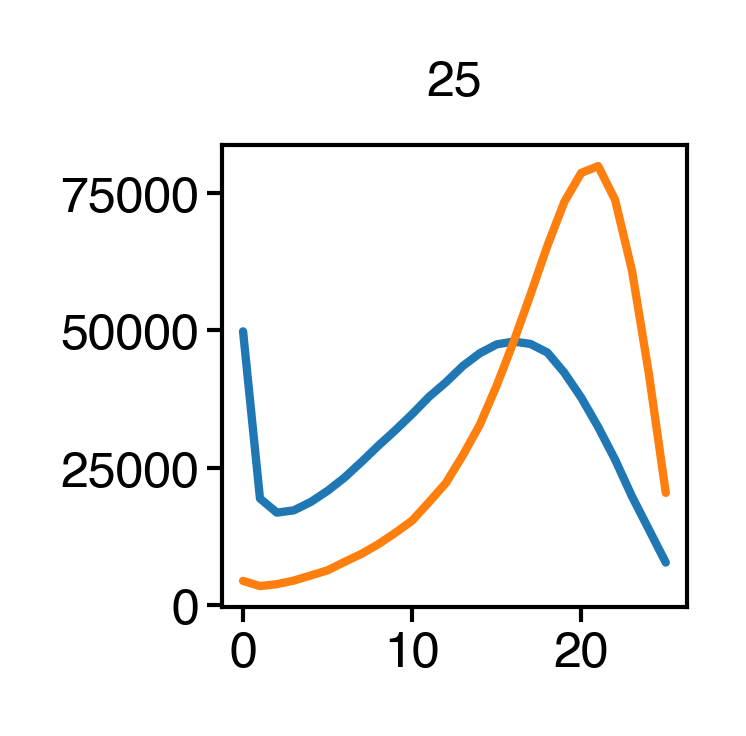

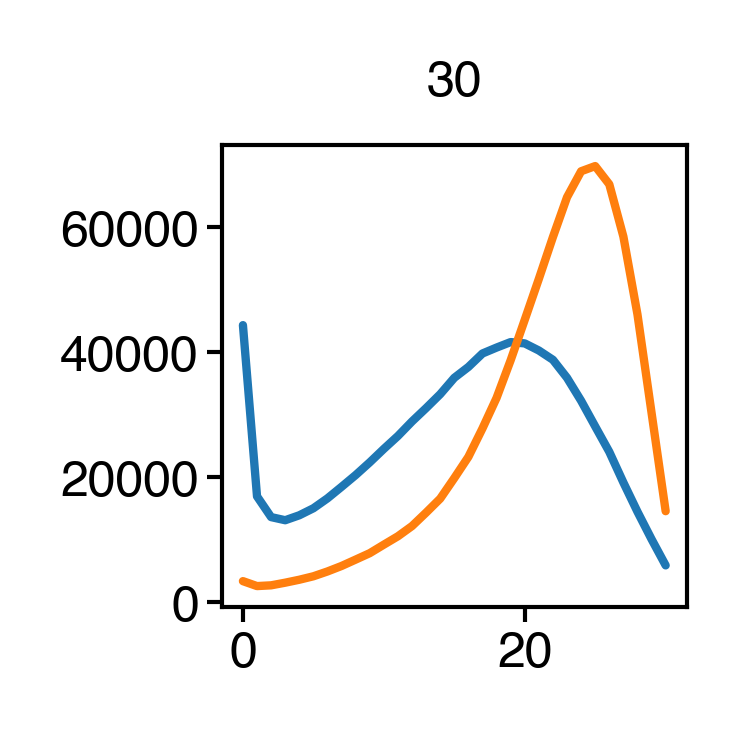

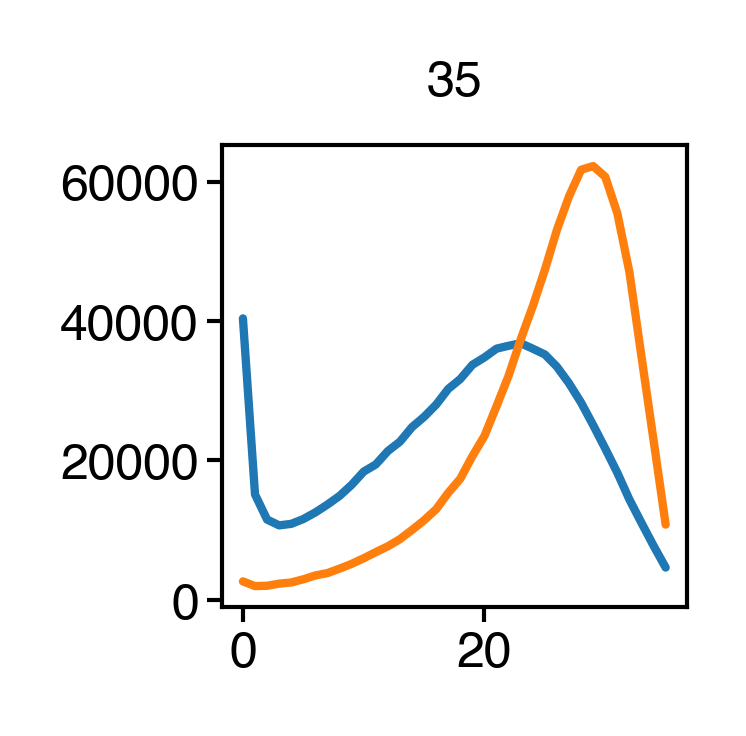

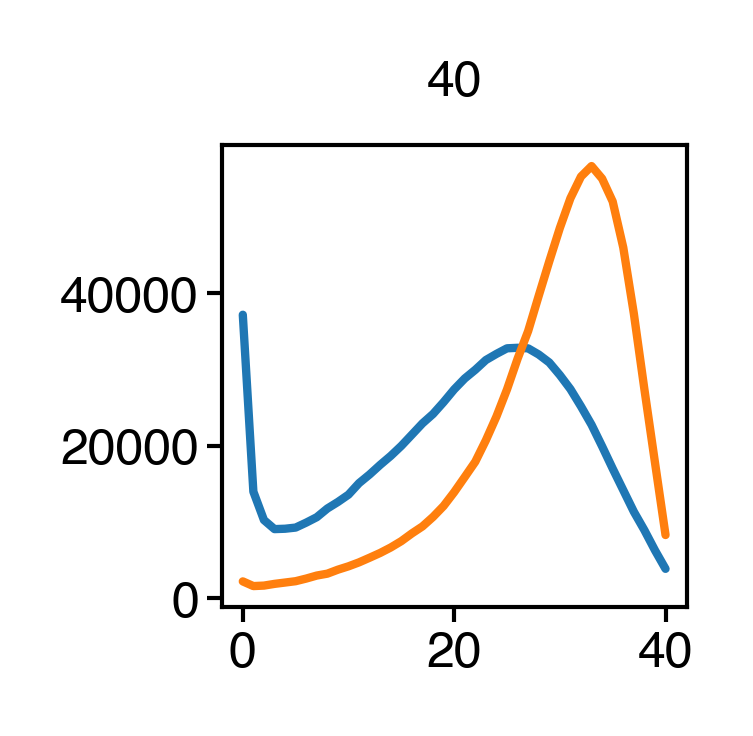

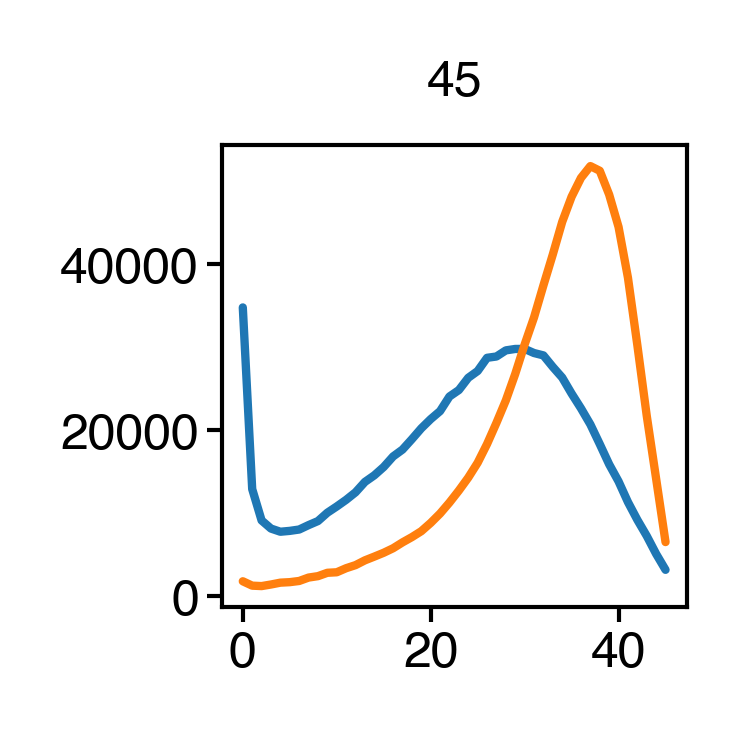

In [133]:
for k, (h1, h2) in hists.items():
    figure(1, 1)
    plt.plot(h1)
    plt.plot(h2)
    plt.title(k)

<Axes: >

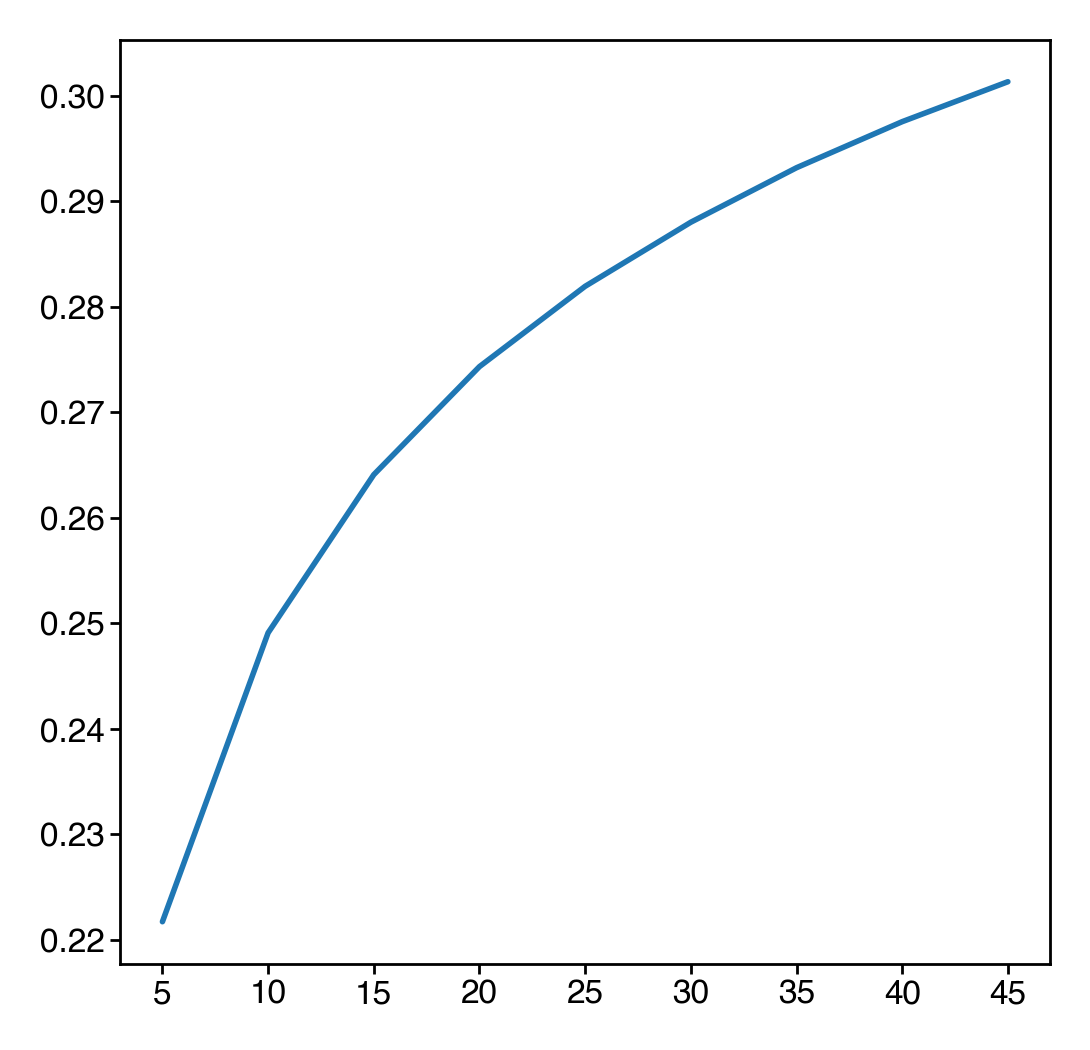

In [134]:
pd.Series(opt).plot()

## TODO: use holoviews to visualize frames at different points